In [ ]:
from qiskit.quantum_info import DensityMatrix
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Kraus, SuperOp

n=4
shots = 100000
theta=0.3
# Operatori di Kraus: Identità e Hadamard su entrambi i qubit


# Creazione del canale quantistico multi-qubit


# Creazione di un circuito quantistico su 2 qubit
qc = QuantumCircuit(n, 2)
qc.cx(0,1)

for i in range(n-2):
  qc.cx(i+1, i+2)  # Entanglement con una CNOT
  qc.cx(i-1, i)  # Entanglement con una CNOT



multi_qubit_channel = Kraus([K0, K1])



rho = DensityMatrix(qc)
rho.draw('latex', prefix='\\rho')




QiskitError: 'Kraus operators are different dimensions.'

In [26]:
import qiskit.quantum_info as qi
# Applicazione del canale quantistico collettivo
qc.append(SuperOp(multi_qubit_channel), [0, 1])


rho_AB = qi.DensityMatrix.from_instruction(qc)
rho_AB.draw('latex', prefix='\\phi(\\rho) = ')



CircuitError: 'The amount of qubit arguments 2 does not match the instruction expectation (3).'

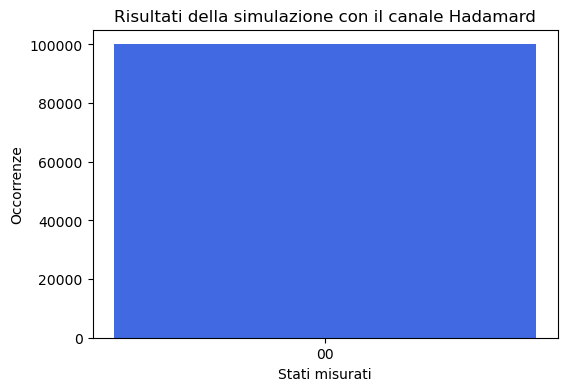

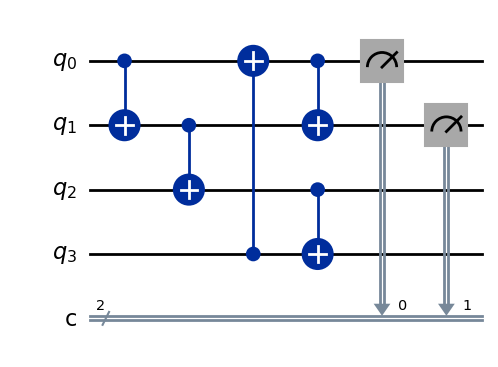

In [ ]:
# Misura dei qubit
qc.measure([0, 1], [0, 1])


# Simulazione
simulator = Aer.get_backend('aer_simulator')
qc = transpile(qc, simulator)
result = simulator.run(qc, shots=shots ).result()

counts = result.get_counts()

# Plot dei risultati
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color='royalblue')
plt.xlabel("Stati misurati")
plt.ylabel("Occorrenze")
plt.title("Risultati della simulazione con il canale Hadamard")
plt.show()
qc.draw(output='mpl')



In [ ]:

# Definizione della matrice Z
Z = np.array([[1, 0,  0,  0],
              [0, -1, 0,  0],
              [0, 0, -1,  0],
              [0, 0,  0,  1]])

print("Matrice Z:\n", Z)

# Calcoliamo il prodotto rho * Z
rho_Z = np.dot(rho_AB, Z)

print("\nProdotto rho * Z:\n", rho_Z)

# Calcoliamo la traccia di rho_Z
trace_rho_Z = np.trace(rho_Z)

print("\nTraccia di rho * Z:", trace_rho_Z)

Matrice Z:
 [[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]

Prodotto rho * Z:
 [[ 4.89299487e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -4.29901420e-01+1.27044557e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -4.56333904e-02+0.00000000e+00j
  -1.93746982e-33+0.00000000e+00j  4.77668245e-02+1.41160618e-02j]
 [ 4.29901420e-01+1.27044557e-01j -1.93746982e-33+0.00000000e+00j
  -4.10700513e-01+0.00000000e+00j  2.02804963e-33+5.99329647e-34j]
 [ 0.00000000e+00+0.00000000e+00j -4.77668245e-02+1.41160618e-02j
  -2.02804963e-33+5.99329647e-34j  5.43666096e-02+0.00000000e+00j]]

Traccia di rho * Z: (0.08733219254516078+0j)


In [ ]:
import qiskit.quantum_info as qi
# Applicazione del canale quantistico collettivo
qc.append(SuperOp(multi_qubit_channel), [0, 1])


rho_AB = qi.DensityMatrix.from_instruction(qc)
rho_AB.draw('latex', prefix='\\phi(\\rho) = ')



QiskitError: 'Cannot convert QuantumChannel to Instruction: channel is not CPTP.'

In [ ]:
from qiskit_aer.noise import QuantumError, NoiseModel

# 1. Input: numero di qubit e probabilità di rumore
n = 2
p = 0.2

# 2. Genera l'osservabile H
h = 9 / n
d = 2 ** n  # dimensione dello spazio degli stati
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

H_mat = np.zeros((d, d))
for k in range(0, n - 1, 2):
    op = 1
    for qubit in range(n):
        if qubit == k or qubit == k + 1:
            op = np.kron(op, Z)
        else:
            op = np.kron(op, I)
    H_mat += op
H_mat = h * H_mat
print("Osservabile H generato:\n", H_mat)

# 3. Creazione del circuito ansatz semplice
theta = 0.3
qc = QuantumCircuit(n)
for i in range(n):
    qc.rx(theta, i)
for i in range(n - 1):
    qc.cx(i, i + 1)

# 4. Definizione del canale di rumore personalizzato
GHZ = np.zeros((d, 1), dtype=complex)
GHZ[0] = 1 / np.sqrt(2)
GHZ[-1] = 1 / np.sqrt(2)

K1 = np.sqrt(1 - p) * np.eye(d)
K2_list = []
for i in range(d):
    ket_i = np.zeros((d, 1), dtype=complex)
    ket_i[i, 0] = 1.0
    K2 = np.sqrt(p / d) * np.dot(GHZ, ket_i.conj().T)
    K2_list.append(K2)
kraus_ops = [K1] + K2_list

noise_error = QuantumError(kraus_ops)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(noise_error, ['id'])

for i in range(n):
    qc.id(i)

print("\nCircuito ansatz con rumore:")
print(qc.draw())

# 5. Simulazione del circuito con il noise model
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, noise_model=noise_model, shots=1024, parameter_binds=[{theta: 0.5}])
result = job.result()
counts = result.get_counts(qc)
print("\nRisultati della simulazione (counts):", counts)

# (Opzionale) Simulazione dello statevector finale con il noise model
backend_sv = Aer.get_backend('statevector_simulator')
job_sv = execute(qc, backend_sv, noise_model=noise_model, parameter_binds=[{theta: 0.5}])
result_sv = job_sv.result()
statevector = result_sv.get_statevector(qc)
print("\nStatevector finale (con rumore):\n", statevector)


Osservabile H generato:
 [[ 4.5  0.   0.   0. ]
 [ 0.  -4.5  0.   0. ]
 [ 0.   0.  -4.5  0. ]
 [ 0.   0.   0.   4.5]]


NoiseError: "Invalid type of input is found around '[[0.89442719 0.         0.         0.        ]\n [0.         0.89442719 0.         0.        ]\n [0.         0.         0.89442719 0.        ]\n [0.         0.         0.         0.89442719]]'"